<a href="https://colab.research.google.com/github/yashpatel5400/crypto-prediction/blob/main/stats_601_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.linear_model import Ridge 
from sklearn.linear_model import LinearRegression
import urllib.request

url = "https://media.githubusercontent.com/media/yashpatel5400/crypto-prediction/main/log_pr.csv"
urllib.request.urlretrieve(url, "log_pr.csv")

url = "https://media.githubusercontent.com/media/yashpatel5400/crypto-prediction/main/volu.csv"
urllib.request.urlretrieve(url, "volu.csv")

('volu.csv', <http.client.HTTPMessage at 0x7fc788de0050>)

In [255]:
log_pr = pd.read_csv("log_pr.csv", index_col= 0)
volu = pd.read_csv("volu.csv", index_col= 0)

log_pr.index = pd.to_datetime(log_pr.index)
volu.index = pd.to_datetime(volu.index)

print(log_pr.shape)

num_test = int(len(log_pr)*0.39)
log_pr_test = log_pr.iloc[-num_test:]
log_pr = log_pr.iloc[:-num_test]

volu_test = volu.iloc[-num_test:]
volu = volu.iloc[:-num_test]

print(log_pr_test.shape)


(264960, 10)
(103334, 10)


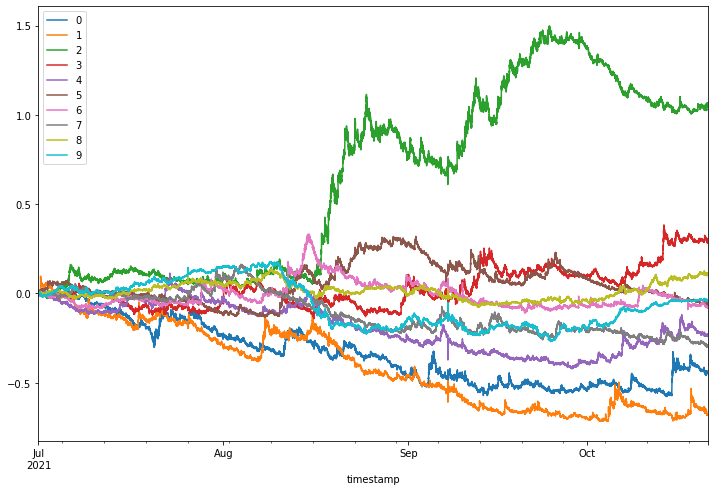

In [256]:
log_pr.plot(figsize=(12, 8))

In [269]:
def construct_features(log_pr_df, vol_df):
    df = log_pr_df.copy()
    ema21 = log_pr_df.ewm(span=21, min_periods=5, adjust=False).mean().fillna(1)
    # ema35 = log_pr_df.ewm(span=35, min_periods=10, adjust=False).mean().fillna(1)
    # ema80 = log_pr_df.ewm(span=80, min_periods=20, adjust=False).mean().fillna(1)
    # ema250 = log_pr_df.ewm(span=250, min_periods=30, adjust=False).mean().fillna(1)

    df = pd.concat([ema21], axis=1)
    return df

In [270]:
def construct_dataset(window_size, features, log_prices):
    """
    window: look-back window size for constructing X (in minutes)
    """
    window_dt = datetime.timedelta(minutes=window_size)
    predict_dt = datetime.timedelta(minutes=30)

    window_X = []
    window_y = []

    for t in features.index[window_size:-window_size:10]: # compute the predictions every 10 minutes
      window_X.append(features.loc[(t - window_dt):t])
      window_y.append(log_prices.loc[t + predict_dt] - log_prices.loc[t])
        
    return np.array(window_X), np.array(window_y)

In [271]:
features = construct_features(log_pr, volu)
window_size = 60 # in minutes
X, y = construct_dataset(window_size, features, log_pr)

X_train = X
y_train = y

print(X_train.shape)
print(y_train.shape)

(16151, 61, 10)
(16151, 10)


#LSTMs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


cuda


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
y_train_tensors = Variable(torch.Tensor(y_train).to(device))

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)

Training Shape torch.Size([25984, 61, 10]) torch.Size([25984, 10])


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.output_size = output_size #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(32, output_size) #fully connected last layer
    
    def forward(self,x):
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc1(hn)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 100 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = X_train.shape[-1] #number of features
print(input_size)
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 10 #number of output classes

lstm1 = LSTM1(output_size, input_size, hidden_size, num_layers) 
lstm1 = lstm1.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

print(X_train_tensors.shape)

10
torch.Size([25984, 61, 10])


In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) 
  optimizer.zero_grad() 
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() 
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 2 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.00979
Epoch: 2, loss: 0.00843
Epoch: 4, loss: 0.00724
Epoch: 6, loss: 0.00600
Epoch: 8, loss: 0.00471


KeyboardInterrupt: ignored

In [ ]:
lstm1 = lstm1.to(torch.device("cpu"))
torch.save(lstm1.state_dict(), "/content/lstm_model.pth")

In [ ]:
print( np.expand_dims(log_pr.iloc[-31:, :].to_numpy(), 0).shape)

In [ ]:
lstm1.load_state_dict(torch.load("/content/lstm_model.pth"))
lstm1.eval()
lstm1 = lstm1.to(torch.device("cpu"))

#GBoost

In [183]:
model_0 = lgb.LGBMRegressor()
print(X_train.shape)
X_train_asset0 = np.array(X_train[:, :, 0])
X_train_asset2 = np.array(X_train[:, :, 2])
X_train_asset3 = np.array(X_train[:, :, 3])
X_train_asset1 = np.array(X_train[:, :, 1])

y_train_asset0 = np.array(y_train[:, 0])
y_train_asset2 = np.array(y_train[:, 2])
y_train_asset3 = np.array(y_train[:, 3])
y_train_asset1 = np.array(y_train[:, 1])

model_2 = lgb.LGBMRegressor()
model_3 = lgb.LGBMRegressor()
model_1 = lgb.LGBMRegressor()


model_0.fit(X_train_asset0, y_train_asset0)
model_2.fit(X_train_asset2, y_train_asset2)
model_3.fit(X_train_asset3, y_train_asset3)
model_1.fit(X_train_asset1, y_train_asset1)

model_0.booster_.save_model('model_0.txt')
model_2.booster_.save_model('model_2.txt')
model_3.booster_.save_model('model_3.txt')
model_1.booster_.save_model('model_1.txt')

(16151, 61, 10)


In [184]:
model_0 = lgb.Booster(model_file='model_0.txt')
model_2 = lgb.Booster(model_file='model_2.txt')
model_3 = lgb.Booster(model_file='model_3.txt')
model_1 = lgb.Booster(model_file='model_1.txt')

#GBoost + Ridge

In [272]:
model_2 = lgb.LGBMRegressor()
model_01 = Ridge()
model_35 = Ridge()

X_train_asset2 = np.array(X_train[:, :, 2])
X_train_asset01 = np.concatenate((X_train[:, :, 0], X_train[:, :, 1]), axis=1)
X_train_asset35 = np.concatenate((X_train[:, :, 3], X_train[:, :, 5]), axis=1)

y_train_asset2 = np.array(y_train[:, 2])
y_train_asset01 = np.concatenate((y_train[:, 0:1], y_train[:, 1:2]), axis=1)
y_train_asset35 = np.concatenate((y_train[:, 3:4], y_train[:, 5:6]), axis=1)

model_2.fit(X_train_asset2, y_train_asset2)
model_01.fit(X_train_asset01, y_train_asset01)
model_35.fit(X_train_asset35, y_train_asset35)



Ridge()

#Evaluation

In [273]:
# Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns
#predict the log price, and then do correlation

def get_r_hat_baseline(A, B):
    return -(A.iloc[-1] - A.iloc[-30]).values 

In [274]:
def get_r_hat_lstm(A, B):
  input = np.expand_dims(construct_features(A, B).values, axis=0)
  input = Variable(torch.Tensor(input))
  pred = lstm1(input).detach().cpu().numpy()
  return pred.squeeze()

In [275]:
def get_r_hat_complex(A, B):
  input = construct_features(A, B)
  tmp = -(input.iloc[-1] - input.iloc[-30]).values
  asset_0_pred = model_0.predict(np.expand_dims(input.iloc[-61:, 0].values, axis=0)) 
  asset_2_pred = model_2.predict(np.expand_dims(input.iloc[-61:, 2].values, axis=0))
  asset_3_pred = model_3.predict(np.expand_dims(input.iloc[-61:, 3].values, axis=0))
  asset_1_pred = model_1.predict(np.expand_dims(input.iloc[-61:, 1].values, axis=0))
  tmp[0] = asset_0_pred[0]
  tmp[2] = asset_2_pred[0]
  tmp[3] = asset_3_pred[0]
  tmp[1] = asset_1_pred[0]

  return tmp

In [276]:
def get_r_hat_simple(A, B):
  input = construct_features(A, B)
  return -(input.iloc[-1] - input.iloc[-30]).values 

In [277]:
def get_r_hat_ridge_boost(A, B):
  input = construct_features(A, B)
  tmp = -(input.iloc[-1] - input.iloc[-30]).values
  asset_2_pred = model_2.predict(np.expand_dims(input.iloc[-61:, 2].values, axis=0))

  input_01 = np.concatenate((input.iloc[-61:, 0:1].values, input.iloc[-61:, 1:2].values), axis=1).reshape(1, -1)
  asset_01_pred = np.squeeze(model_01.predict(input_01))

  input_35 = np.concatenate((input.iloc[-61:, 3:4].values, input.iloc[-61:, 5:6].values), axis=1).reshape(1, -1)
  asset_35_pred = np.squeeze(model_35.predict(input_35))

  tmp[2] = asset_2_pred[0]
  tmp[0] = asset_01_pred[0]
  tmp[1] = asset_01_pred[1]
  tmp[3] = asset_35_pred[0]
  tmp[5] = asset_35_pred[1]


  return tmp


In [281]:
# An example of get_r_hat

ACTIVE_R_HAT = "ridge_boost"

r_hat_implementations = {
    "baseline": get_r_hat_baseline, 
    "lstm": get_r_hat_lstm,
    "simple":get_r_hat_simple,
    "complex": get_r_hat_complex, 
    "ridge_boost": get_r_hat_ridge_boost
}

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    return r_hat_implementations[ACTIVE_R_HAT](A, B)

In [282]:
def get_model_corr(test_log_pr, test_volu):
    t0 = time.time()
    dt = datetime.timedelta(days=1)
    r_hat = pd.DataFrame(index=test_log_pr.index[1440::10], columns=np.arange(10), dtype=np.float64)
    for t in test_log_pr.index[1440::10]: # compute the predictions every 10 minutes
        r_hat.loc[t, :] = get_r_hat(test_log_pr.loc[(t - dt):t], test_volu.loc[(t - dt):t])
    t_used = time.time() - t0
    
    r_fwd = (test_log_pr.shift(-30) - test_log_pr).iloc[1440::10].rename(columns={f"input_df_{i}": i for i in range(10)})
    r_fwd.corrwith(r_hat)
    
    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final "ignore_rows" rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

In [283]:
# log_pr_test = log_pr.iloc[-num_test:]
# volu_test = volu.iloc[-num_test:]
t0 = time.time()
ans = get_model_corr(log_pr_test, volu_test)
t_used = time.time() - t0
print("time used", t_used)
print("correlation", ans)

time used 9.323682308197021
correlation 0.011229622497174383
